In [1]:
import pandas as pd
import numpy as np
import os
import random
import albumentations as A
import timm
from fastai.vision.all import *
from sklearn.model_selection import StratifiedKFold
from fastai.metrics import F1Score,accuracy
import gc
import torch
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(42, True)

In [3]:
import os, shutil

def safe_delete(path):
    """Delete a folder if it exists."""
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Deleted: {path}")
    else:
        print(f"Path not found: {path}")

# Usage
safe_delete('/kaggle/working/models/')

Path not found: /kaggle/working/models/


In [4]:
# Normalize reflectance values (0–10000) to 0–255
def normalize_to_uint8(img):
    img = np.clip(img, 0, 10000)
    img = img / 10000.0
    img = (img * 255).astype(np.uint8)
    return img

In [5]:
# Load the 12-band file
img = np.load('/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data/ID_01BKNN.npy')  # shape: (12, H, W)

# Check shape and value range
print(f"Shape: {img.shape}, dtype: {img.dtype}")
print(f"Min: {img.min()}, Max: {img.max()}")

Shape: (64, 64, 12), dtype: float64
Min: -34.80948238356924, Max: 12449.0


In [6]:
import os
from tqdm import tqdm

npy_folder = "/kaggle/input/slideandseekclasificationlandslidedetectiondataset/train_data/train_data"
output_folder = "train_data_sentinel_png"
os.makedirs(output_folder, exist_ok=True)

for filename in tqdm(os.listdir(npy_folder)):
    if filename.endswith(".npy"):
        path = os.path.join(npy_folder, filename)
        data = np.load(path)
        
        rgb = data[:, :, [3, 2, 1]]  # RGB composite
        rgb = normalize_to_uint8(rgb)

        image_pil = Image.fromarray(rgb)
        out_path = os.path.join(output_folder, filename.replace(".npy", ".png"))
        image_pil.save(out_path)

100%|██████████| 7147/7147 [01:17<00:00, 91.96it/s] 


In [7]:
import os
from tqdm import tqdm

npy_folder = "/kaggle/input/slideandseekclasificationlandslidedetectiondataset/test_data/test_data"
output_folder = "test_data_sentinel_png"
os.makedirs(output_folder, exist_ok=True)

for filename in tqdm(os.listdir(npy_folder)):
    if filename.endswith(".npy"):
        path = os.path.join(npy_folder, filename)
        data = np.load(path)
        
        rgb = data[:, :, [3, 2, 1]]  # RGB composite
        rgb = normalize_to_uint8(rgb)

        image_pil = Image.fromarray(rgb)
        out_path = os.path.join(output_folder, filename.replace(".npy", ".png"))
        image_pil.save(out_path)

100%|██████████| 5397/5397 [00:56<00:00, 96.28it/s]


In [8]:
PATH = "/kaggle/input/slideandseekclasificationlandslidedetectiondataset"
TRAIN_IMAGE_PATH = "/kaggle/working/train_data_sentinel_png/"
TEST_IMAGE_PATH = "/kaggle/working/test_data_sentinel_png/"
'nir', 'green', 'blue'
drop_ids = [
    "ID_Z29R76"
]
train = pd.read_csv(PATH + "/Train.csv")
test_df = pd.read_csv(PATH + "/Test.csv")
train['image_path'] = TRAIN_IMAGE_PATH + train['ID'] + '.png'
train = train[~train['ID'].isin(drop_ids)].reset_index(drop=True)
test_df['image_path'] = TEST_IMAGE_PATH + test_df['ID'] + '.png'
display(train.head(), test_df.head(), train.shape, test_df.shape)


,ID,label,image_path
0,ID_HUD1ST,1,/kaggle/working/train_data_sentinel_png/ID_HUD1ST.png
1,ID_KGE2HY,1,/kaggle/working/train_data_sentinel_png/ID_KGE2HY.png
2,ID_VHV9BL,1,/kaggle/working/train_data_sentinel_png/ID_VHV9BL.png
3,ID_ZT0VEJ,0,/kaggle/working/train_data_sentinel_png/ID_ZT0VEJ.png
4,ID_5NFXVY,0,/kaggle/working/train_data_sentinel_png/ID_5NFXVY.png


,ID,image_path
0,ID_ICB8K9,/kaggle/working/test_data_sentinel_png/ID_ICB8K9.png
1,ID_2D4AOJ,/kaggle/working/test_data_sentinel_png/ID_2D4AOJ.png
2,ID_2TVPI0,/kaggle/working/test_data_sentinel_png/ID_2TVPI0.png
3,ID_E05WIK,/kaggle/working/test_data_sentinel_png/ID_E05WIK.png
4,ID_KKFDJO,/kaggle/working/test_data_sentinel_png/ID_KKFDJO.png


(7146, 3)

(5398, 2)

In [9]:
timm.list_models("eva*")

['eva02_base_patch14_224',
 'eva02_base_patch14_448',
 'eva02_base_patch16_clip_224',
 'eva02_enormous_patch14_clip_224',
 'eva02_large_patch14_224',
 'eva02_large_patch14_448',
 'eva02_large_patch14_clip_224',
 'eva02_large_patch14_clip_336',
 'eva02_small_patch14_224',
 'eva02_small_patch14_336',
 'eva02_tiny_patch14_224',
 'eva02_tiny_patch14_336',
 'eva_giant_patch14_224',
 'eva_giant_patch14_336',
 'eva_giant_patch14_560',
 'eva_giant_patch14_clip_224',
 'eva_large_patch14_196',
 'eva_large_patch14_336']

In [10]:
class Config:
  n_splits = 5
  seed = 42
  image_size = 224
  model_name = "eva02_large_patch14_224.mim_m38m"  # # convnext_large.fb_in22k_ft_in1k 
  batch_size = 16
  epochs = 7
  tta = 5
  num_classes = 2

CFG = Config()
CFG.n_splits

5

In [11]:
skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['label'])):
  train.loc[val_idx, 'fold'] = fold
print(train['fold'].value_counts())

fold
0    1430
4    1429
2    1429
1    1429
3    1429
Name: count, dtype: int64


In [12]:
train

,ID,label,image_path,fold
0,ID_HUD1ST,1,/kaggle/working/train_data_sentinel_png/ID_HUD1ST.png,4
1,ID_KGE2HY,1,/kaggle/working/train_data_sentinel_png/ID_KGE2HY.png,0
2,ID_VHV9BL,1,/kaggle/working/train_data_sentinel_png/ID_VHV9BL.png,0
3,ID_ZT0VEJ,0,/kaggle/working/train_data_sentinel_png/ID_ZT0VEJ.png,2
4,ID_5NFXVY,0,/kaggle/working/train_data_sentinel_png/ID_5NFXVY.png,1
...,...,...,...,...
7141,ID_7RINJF,1,/kaggle/working/train_data_sentinel_png/ID_7RINJF.png,4
7142,ID_UAYBOC,0,/kaggle/working/train_data_sentinel_png/ID_UAYBOC.png,2
7143,ID_M0YJD0,0,/kaggle/working/train_data_sentinel_png/ID_M0YJD0.png,3
7144,ID_PI0GHW,0,/kaggle/working/train_data_sentinel_png/ID_PI0GHW.png,4


In [13]:
random_seed(42, True)
class AlbumentationsTransform(RandTransform):
  split_idx, order = None, 2
  def __init__(self, train_aug, valid_aug): store_attr()

  def before_call(self, b, split_idx):
    self.idx = split_idx

  def encodes(self, img: PILImage):
    if self.idx == 0:
      aug_img = self.train_aug(image=np.array(img))['image']
    else:
      aug_img = self.valid_aug(image=np.array(img))['image']
    return PILImage.create(aug_img)

In [14]:
random_seed(42, True)
import albumentations
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(CFG.image_size, CFG.image_size), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(CFG.image_size, CFG.image_size),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

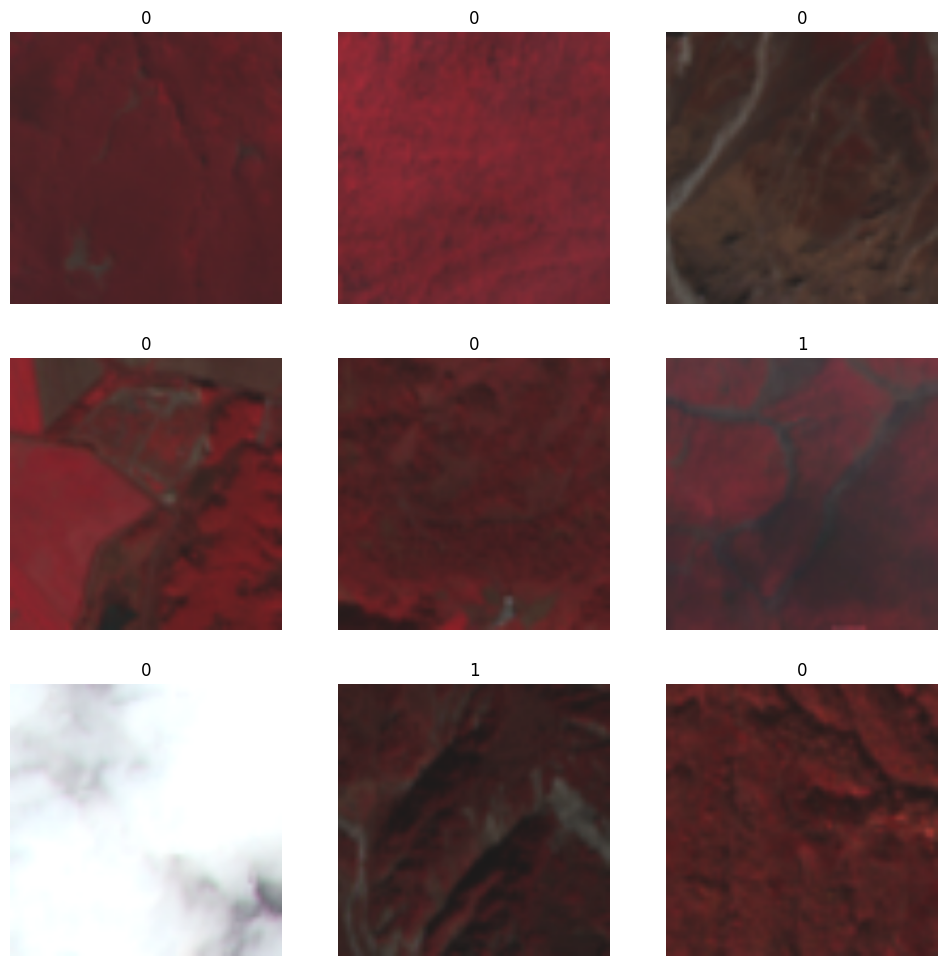

In [15]:
random_seed(42, True)

def get_datablock(train, fold=0, bs = CFG.batch_size):
  return DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_x = ColReader('image_path'),
      get_y = ColReader('label'),
      splitter = IndexSplitter(train[train['fold'] == fold].index),
      item_tfms = item_tfms,
      batch_tfms = batch_tfms
  ).dataloaders(train, bs=bs, seed= CFG.seed)

get_datablock(train).show_batch(figsize = (12,12))

In [16]:
random_seed(42, True)
f1_score = F1Score(average='binary')
metrics = [accuracy, f1_score]


=== Training Fold 4 ===
Validating on fold 4, training on [0, 1, 2, 3]
----------------------------------------------------------------------------------------------------


model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.383916,0.222709,0.907628,0.698630,07:14


Better model found at epoch 0 with f1_score value: 0.6986301369863014.


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.246618,0.168426,0.929321,0.776053,09:51
1,0.199232,0.185853,0.925122,0.737101,09:51
2,0.179896,0.143429,0.939818,0.800926,09:51
3,0.144329,0.093962,0.959412,0.888031,09:51
4,0.065454,0.106852,0.958712,0.877339,09:51
5,0.029844,0.104339,0.966410,0.904000,09:51
6,0.014095,0.108955,0.966410,0.904000,09:51


Better model found at epoch 0 with f1_score value: 0.7760532150776053.
Better model found at epoch 2 with f1_score value: 0.800925925925926.
Better model found at epoch 3 with f1_score value: 0.888030888030888.
Better model found at epoch 5 with f1_score value: 0.904.
Saved model for fold 4 at models_folds/eva02_large_patch14_224.mim_m38m_fold4.pkl


Saved predictions for fold 4

=== Finished this chunk ===


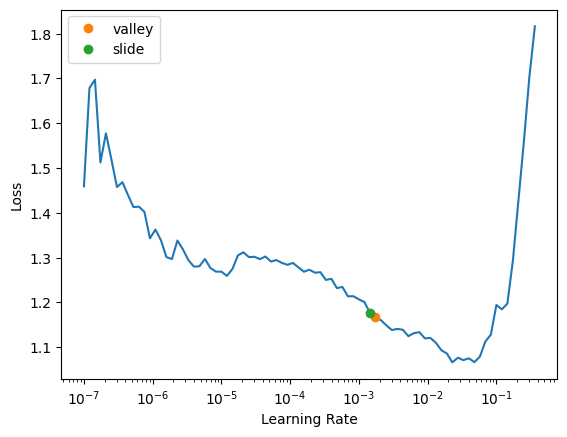

In [ ]:
import os, gc, torch
import numpy as np
from fastai.vision.all import *

# Configurable folds for this run
FOLDS_TO_TRAIN = [4]  # <-- Change to [2,3], then [4] in later runs

# Directory to store models & predictions
os.makedirs("models_folds", exist_ok=True)

oof_preds = np.zeros((len(train), CFG.num_classes))

for fold in range(CFG.n_splits):
    if fold in FOLDS_TO_TRAIN:
        print(f"\n=== Training Fold {fold} ===")
        print(f"Validating on fold {fold}, training on {[i for i in range(CFG.n_splits) if i != fold]}")
        print("-"*100)

        # Data
        dls = get_datablock(train, fold, CFG.batch_size)
        set_seed(42, reproducible=True) 

        # Model
        learn = vision_learner(
            dls,
            CFG.model_name,
            loss_func=CrossEntropyLossFlat(),
            metrics=metrics,
            cbs=[SaveModelCallback(monitor='f1_score', comp=np.greater)]
        )

        set_seed(42, reproducible=True) 
        _valley, _slide = learn.lr_find(suggest_funcs=(valley, slide))
        set_seed(42, reproducible=True) 
        learn.fine_tune(CFG.epochs, _valley)

        # Save model
        model_path = f"models_folds/{CFG.model_name}_fold{fold}.pkl"
        learn.export(model_path)
        print(f"Saved model for fold {fold} at {model_path}")

        # Validation preds (OOF)
        val_idx = train[train['fold'] == fold].index
        val_dl = learn.dls.valid
        val_preds, _ = learn.tta(dl=val_dl, n=CFG.tta)
        np.save(f"models_folds/oof_preds_fold{fold}.npy", val_preds.numpy())
        oof_preds[val_idx] = val_preds.numpy()

        # Test preds
        test_dl = learn.dls.test_dl(test_df)
        preds, _ = learn.tta(dl=test_dl, n=CFG.tta)
        np.save(f"models_folds/test_preds_fold{fold}.npy", preds.numpy())
        print(f"Saved predictions for fold {fold}")

        # Cleanup
        del learn, dls
        gc.collect()
        torch.cuda.empty_cache()

print("\n=== Finished this chunk ===")

In [18]:
# train[['ID', 'label', 'oof_prob']].to_csv(f"oof_train_{CFG.model_name}.csv", index=False)

# from sklearn.metrics import f1_score

# train['predicted_label'] = train['oof_preds'].apply(
#     lambda preds: 1 if preds[1] > 0.5 else 0
# )
# y_true = train['label'].apply(int).values
# y_pred = train['predicted_label'].apply(int).values

# print("F1_Score", f1_score(y_true, y_pred))

# all_preds_array = np.array([pred for pred in all_preds ])
# mean_test_preds = all_preds_array.mean(axis = 0)
# len(mean_test_preds)

# np.argmax(mean_test_preds, axis = 1)

# test_df['Probs'] = mean_test_preds[:, 1]

# sub_prob = test_df[['ID', 'Probs']]
# sub_prob.columns = ['ID', 'Probs']
# sub_prob.head()

# sub_prob.to_csv(f"Probs_{CFG.model_name}_all_folds.csv", index= False)

# test_df['label'] = np.argmax(mean_test_preds, axis = 1)
# test_df['label'].head()

# test_df['label'].value_counts()

# sub = test_df[['ID', 'label']]
# sub.columns = ['ID', 'target']
# sub.head()

# sub.to_csv(f"{CFG.model_name}_all_folds.csv", index= False)